## Approach: CNN + MLP (Trained with Supervised Contrastive Learning)

In [1]:
#Import All libraries 
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import optuna
import torch.nn as nn
import torch.nn.functional as F
from pytorch_metric_learning.losses import SupConLoss
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from torchsummary import summary

In [2]:
#Perfom the transformations necessary 
transform = transforms.Compose([
    transforms.ToTensor(),                     #Transform the image into a tensor 
    transforms.Normalize((0.1307,), (0.3081,)) #Normalize the data
])

# Load the MNIST Dataset
full_train_data = datasets.MNIST(root=".\MNIST\MNIST_Train", train=True, download=False, transform = transform)
test_data = datasets.MNIST(root=".\MNIST\MNIST_Test", train=False, download=False, transform = transform)

# This seed is used to make sure the same split will happen for all approaches
torch.manual_seed(42)  

# Defining the sets that are going to be used for training and Gridsearch
train_data = int(0.7 * len(full_train_data))  # 70% for training
train_gridsearch = len(full_train_data) - train_data # 30% for gridsearch

# Get the training sets 
train_data, train_gridsearch = random_split(full_train_data, [train_data, train_gridsearch])

# Split the training datasets, one for the training of the CNN and one for the training of the MLP 
train_CNN = int(0.6 * len(train_data))
train_MLP = len(train_data) - train_CNN
train_CNN, train_MLP = random_split(train_data, [train_CNN, train_MLP])

# Make the Training and Validation split of the train_gridsearch set
train_gridsearch2 = int(0.8 * len(train_gridsearch))
validation_gridsearch = len(train_gridsearch) - train_gridsearch2
train_gridsearch2, validation_gridsearch = random_split(train_gridsearch, [train_gridsearch2, validation_gridsearch])

# Make the split of the train_gridsearch2 for the CNN and the MLP
train_gridsearch2_CNN = int(0.6 * len(train_gridsearch2))
train_gridsearch2_MLP = len(train_gridsearch2) - train_gridsearch2_CNN
train_gridsearch2_CNN, train_gridsearch2_MLP = random_split(train_gridsearch2, [train_gridsearch2_CNN, train_gridsearch2_MLP])

# the device specifies where the tensor or model should be stored and computations should be performed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class CNNEncoder(nn.Module): #Encoder as we're only interest in the final embedding provided by the CNN 
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(p=0.3) #Dropout
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(256 * 7 * 7, 128)  # Output: 128-dimension embeddings

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # 14x14
        
        x = self.dropout1(F.relu(self.conv3(x))) #Adding Dropout
        x = F.relu(self.conv4(x))
        x = self.pool(x)  # 7x7
        
        x = x.view(-1, 256 * 7 * 7)  # Flatten
        x = self.fc(x)  # Output embeddings
        
         # Normalize embeddings to lie on unit hypersphere
        x = F.normalize(x, p=2, dim=1)  # L2 normalization
        
        return x

class MLPClassifier(nn.Module): # MLP projection Head 
    def __init__(self):
        super(MLPClassifier, self).__init__()
        self.dropout2 = nn.Dropout(p=0.3) #Dropout
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.dropout2(F.relu(self.fc1(x))) #Adding Dropout
        x = self.fc2(x)
        return x

In [4]:
# Initialize accuracy calculator
#accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), knn_func=None)
class ContrastiveTrainer:
    def __init__(self, encoder, classifier, criterion, optimizer):
        self.encoder = encoder
        self.classifier = classifier
        self.criterion = criterion
        self.optimizer = optimizer

    def train_contrastive(self, train_loader, epochs):
        self.encoder.train()
        for epoch in range(epochs):
            total_loss = 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                self.optimizer.zero_grad()

                # Forward pass through the encoder
                features = self.encoder(images)

                # Compute supervised contrastive loss
                loss = self.criterion(features, labels)
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()
            print(f'Epoch [{epoch + 1}/{epochs}], Contrastive Loss: {total_loss / len(train_loader):.4f}')
    
    def train_classifier(self, train_loader, epochs):
        self.encoder.eval()  # Freeze the encoder for classifier training
        self.classifier.train()
        
        for epoch in range(epochs):
            total_loss = 0
            correct = 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                self.optimizer.zero_grad()

                # Extract frozen features
                with torch.no_grad():
                    features = self.encoder(images)

                # Forward pass through the classifier
                outputs = self.classifier(features)
                loss = F.cross_entropy(outputs, labels)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()

            accuracy = correct / len(train_loader.dataset)
            print(f'Epoch [{epoch + 1}/{epochs}], Cross Entropy Loss: {total_loss / len(train_loader):.4f}, Accuracy: {accuracy * 100:.2f}%')

    def test_classifier(self, test_loader, num_classes=10):
        self.encoder.eval()
        self.classifier.eval()
        
        # Variables to store predictions and true labels for AUC/ROC/Confusion Matrix
        all_probs = []
        all_labels = []
        all_preds = []
        
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Get features and outputs
                features = self.encoder(images)
                outputs = self.classifier(features)
                
                # Convert logits to probabilities using softmax
                probs = F.softmax(outputs, dim=1)
                
                # Record the true labels and predicted probabilities
                all_labels.append(labels.cpu().numpy())
                all_probs.append(probs.cpu().numpy())
                
                # Get predicted class from the output (class with max probability)
                _, predicted = torch.max(outputs, 1)
                all_preds.append(predicted.cpu().numpy())
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # Flatten the collected lists
        all_labels = np.concatenate(all_labels)
        all_probs = np.concatenate(all_probs)
        all_preds = np.concatenate(all_preds)
        # Calculate test accuracy
        accuracy = 100 * correct / total
        print(f'Test Accuracy: {accuracy:.2f}%')
        
        # --- ROC and AUC computation ---
        # One-hot encode the labels
        labels_one_hot = np.eye(num_classes)[all_labels]

        # Compute ROC and AUC for each class
        roc_auc = {}
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(labels_one_hot[:, i], all_probs[:, i])
            auc = roc_auc_score(labels_one_hot[:, i], all_probs[:, i])
            roc_auc[f'Class {i}'] = auc
            print(f'Class {i} AUC: {auc:.4f}')
            
        # Plot the ROC curve for each class
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc:.2f})')
        
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()
        
        # Overall macro AUC score
        overall_auc = roc_auc_score(labels_one_hot, all_probs, average='macro')
        print(f'Overall AUC (macro): {overall_auc:.4f}')
        
        # --- Confusion Matrix ---
        # Compute confusion matrix
        conf_matrix = confusion_matrix(all_labels, all_preds)
        
        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(num_classes))
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.show()

In [5]:
# Hyperparameter tuning with Optuna
def objective(trial):

    # Hyperparameters to tune
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 32, 128, step=32)
    
    # Create data loaders
    train_gridsearch2_CNN_loader = DataLoader(train_gridsearch2_CNN, batch_size=batch_size, shuffle=True)
    train_gridsearch2_MLP_loader = DataLoader(train_gridsearch2_MLP, batch_size=batch_size, shuffle=True)
    validation_gridsearch_loader = DataLoader(validation_gridsearch, batch_size=batch_size, shuffle=False)


    encoder = CNNEncoder().to(device)
    classifier = MLPClassifier().to(device)
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=lr)
    contrastive_loss = SupConLoss().to(device)
    
    trainer = ContrastiveTrainer(encoder, classifier, contrastive_loss, optimizer)
    
    # Train the model
    trainer.train_contrastive(train_gridsearch2_CNN_loader, epochs=5)  # Train for fewer epochs for tuning speed
    trainer.train_classifier(train_gridsearch2_MLP_loader, epochs=3)
    
    # Evaluate on validation data
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_gridsearch_loader:
            images, labels = images.to(device), labels.to(device)
            features = encoder(images)
            outputs = classifier(features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [6]:
# Run Optuna study
study = optuna.create_study(study_name ="Hyperparameter_Tunning",direction='maximize')
study.optimize(objective, n_trials=10)

# Best hyperparameters
print("Best hyperparameters: ", study.best_params)

[I 2024-10-27 08:47:27,176] A new study created in memory with name: Hyperparameter_Tunning


Epoch [1/5], Contrastive Loss: 3.0349
Epoch [2/5], Contrastive Loss: 2.5861
Epoch [3/5], Contrastive Loss: 2.4820
Epoch [4/5], Contrastive Loss: 2.4284
Epoch [5/5], Contrastive Loss: 2.3851
Epoch [1/3], Cross Entropy Loss: 2.2804, Accuracy: 17.19%
Epoch [2/3], Cross Entropy Loss: 2.2301, Accuracy: 39.90%
Epoch [3/3], Cross Entropy Loss: 2.1657, Accuracy: 65.03%


[I 2024-10-27 09:00:23,975] Trial 0 finished with value: 0.7497222222222222 and parameters: {'lr': 0.00010889082037526256, 'batch_size': 96}. Best is trial 0 with value: 0.7497222222222222.


Epoch [1/5], Contrastive Loss: 3.8042
Epoch [2/5], Contrastive Loss: 3.3573
Epoch [3/5], Contrastive Loss: 3.1555
Epoch [4/5], Contrastive Loss: 3.0491
Epoch [5/5], Contrastive Loss: 2.9771
Epoch [1/3], Cross Entropy Loss: 2.3026, Accuracy: 5.28%
Epoch [2/3], Cross Entropy Loss: 2.2986, Accuracy: 7.17%
Epoch [3/3], Cross Entropy Loss: 2.2940, Accuracy: 8.30%


[I 2024-10-27 09:10:32,983] Trial 1 finished with value: 0.08638888888888889 and parameters: {'lr': 1.5419973429468206e-05, 'batch_size': 128}. Best is trial 0 with value: 0.7497222222222222.


Epoch [1/5], Contrastive Loss: 3.1465
Epoch [2/5], Contrastive Loss: 2.6856
Epoch [3/5], Contrastive Loss: 2.5797
Epoch [4/5], Contrastive Loss: 2.5134
Epoch [5/5], Contrastive Loss: 2.4722
Epoch [1/3], Cross Entropy Loss: 2.2999, Accuracy: 11.42%
Epoch [2/3], Cross Entropy Loss: 2.2837, Accuracy: 15.24%
Epoch [3/3], Cross Entropy Loss: 2.2646, Accuracy: 20.36%


[I 2024-10-27 09:20:46,288] Trial 2 finished with value: 0.23555555555555555 and parameters: {'lr': 4.4353578436781926e-05, 'batch_size': 96}. Best is trial 0 with value: 0.7497222222222222.


Epoch [1/5], Contrastive Loss: 2.9417
Epoch [2/5], Contrastive Loss: 2.4966
Epoch [3/5], Contrastive Loss: 2.3970
Epoch [4/5], Contrastive Loss: 2.3474
Epoch [5/5], Contrastive Loss: 2.3177
Epoch [1/3], Cross Entropy Loss: 1.5055, Accuracy: 77.17%
Epoch [2/3], Cross Entropy Loss: 0.3569, Accuracy: 94.27%
Epoch [3/3], Cross Entropy Loss: 0.2014, Accuracy: 95.10%


[I 2024-10-27 09:30:47,150] Trial 3 finished with value: 0.9522222222222222 and parameters: {'lr': 0.0026876147207072864, 'batch_size': 96}. Best is trial 3 with value: 0.9522222222222222.


Epoch [1/5], Contrastive Loss: 2.8968
Epoch [2/5], Contrastive Loss: 2.4868
Epoch [3/5], Contrastive Loss: 2.4054
Epoch [4/5], Contrastive Loss: 2.3514
Epoch [5/5], Contrastive Loss: 2.3066
Epoch [1/3], Cross Entropy Loss: 2.2620, Accuracy: 30.23%
Epoch [2/3], Cross Entropy Loss: 2.1236, Accuracy: 85.14%
Epoch [3/3], Cross Entropy Loss: 1.9002, Accuracy: 94.13%


[I 2024-10-27 09:40:46,754] Trial 4 finished with value: 0.9411111111111111 and parameters: {'lr': 0.0002673683054492845, 'batch_size': 96}. Best is trial 3 with value: 0.9522222222222222.


Epoch [1/5], Contrastive Loss: 2.7643
Epoch [2/5], Contrastive Loss: 2.2812
Epoch [3/5], Contrastive Loss: 2.1596
Epoch [4/5], Contrastive Loss: 2.0841
Epoch [5/5], Contrastive Loss: 2.0428
Epoch [1/3], Cross Entropy Loss: 2.2977, Accuracy: 13.94%
Epoch [2/3], Cross Entropy Loss: 2.2781, Accuracy: 22.14%
Epoch [3/3], Cross Entropy Loss: 2.2559, Accuracy: 27.55%


[I 2024-10-27 09:50:58,573] Trial 5 finished with value: 0.2991666666666667 and parameters: {'lr': 3.8894279667522475e-05, 'batch_size': 64}. Best is trial 3 with value: 0.9522222222222222.


Epoch [1/5], Contrastive Loss: 1.8764
Epoch [2/5], Contrastive Loss: 1.4553
Epoch [3/5], Contrastive Loss: 1.3547
Epoch [4/5], Contrastive Loss: 1.3025
Epoch [5/5], Contrastive Loss: 1.2418
Epoch [1/3], Cross Entropy Loss: 2.2831, Accuracy: 25.09%
Epoch [2/3], Cross Entropy Loss: 2.2314, Accuracy: 53.68%
Epoch [3/3], Cross Entropy Loss: 2.1624, Accuracy: 72.76%


[I 2024-10-27 10:01:11,249] Trial 6 finished with value: 0.7994444444444444 and parameters: {'lr': 4.678682770006793e-05, 'batch_size': 32}. Best is trial 3 with value: 0.9522222222222222.


Epoch [1/5], Contrastive Loss: 1.7699
Epoch [2/5], Contrastive Loss: 1.3733
Epoch [3/5], Contrastive Loss: 1.2820
Epoch [4/5], Contrastive Loss: 1.2239
Epoch [5/5], Contrastive Loss: 1.1909
Epoch [1/3], Cross Entropy Loss: 2.2600, Accuracy: 23.37%
Epoch [2/3], Cross Entropy Loss: 2.0898, Accuracy: 73.87%
Epoch [3/3], Cross Entropy Loss: 1.8257, Accuracy: 90.68%


[I 2024-10-27 10:11:21,422] Trial 7 finished with value: 0.9247222222222222 and parameters: {'lr': 0.00011097183671102424, 'batch_size': 32}. Best is trial 3 with value: 0.9522222222222222.


Epoch [1/5], Contrastive Loss: 3.0427
Epoch [2/5], Contrastive Loss: 2.5314
Epoch [3/5], Contrastive Loss: 2.4165
Epoch [4/5], Contrastive Loss: 2.3640
Epoch [5/5], Contrastive Loss: 2.3266
Epoch [1/3], Cross Entropy Loss: 1.1049, Accuracy: 87.03%
Epoch [2/3], Cross Entropy Loss: 0.1185, Accuracy: 97.88%
Epoch [3/3], Cross Entropy Loss: 0.0798, Accuracy: 98.14%


[I 2024-10-27 10:20:28,835] Trial 8 finished with value: 0.9766666666666667 and parameters: {'lr': 0.003716598164693335, 'batch_size': 96}. Best is trial 8 with value: 0.9766666666666667.


Epoch [1/5], Contrastive Loss: 2.5089
Epoch [2/5], Contrastive Loss: 2.0644
Epoch [3/5], Contrastive Loss: 1.9666
Epoch [4/5], Contrastive Loss: 1.9230
Epoch [5/5], Contrastive Loss: 1.8784
Epoch [1/3], Cross Entropy Loss: 0.7519, Accuracy: 93.82%
Epoch [2/3], Cross Entropy Loss: 0.0889, Accuracy: 97.97%
Epoch [3/3], Cross Entropy Loss: 0.0726, Accuracy: 98.19%


[I 2024-10-27 10:29:54,931] Trial 9 finished with value: 0.9794444444444445 and parameters: {'lr': 0.004225016177751865, 'batch_size': 64}. Best is trial 9 with value: 0.9794444444444445.


Best hyperparameters:  {'lr': 0.004225016177751865, 'batch_size': 64}


In [7]:
# Use best hyperparameters to train the final model
best_params = study.best_params
print(best_params)

{'lr': 0.004225016177751865, 'batch_size': 64}


In [8]:
# Use best hyperparameters to train the final model
train_CNN_loader = DataLoader(train_CNN, batch_size=best_params['batch_size'], shuffle=True)
train_MLP_loader = DataLoader(train_MLP, batch_size=best_params['batch_size'], shuffle=True)
test_loader = DataLoader(test_data, batch_size=best_params['batch_size'], shuffle=False)

# 
encoder = CNNEncoder().to(device)
classifier = MLPClassifier().to(device)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=best_params['lr'])
contrastive_loss = SupConLoss().to(device)


trainer = ContrastiveTrainer(encoder, classifier, contrastive_loss, optimizer)

# Final training and testing
trainer.train_contrastive(train_CNN_loader, epochs=15)
trainer.train_classifier(train_MLP_loader, epochs=10)

Epoch [1/15], Contrastive Loss: 2.1716
Epoch [2/15], Contrastive Loss: 1.9295
Epoch [3/15], Contrastive Loss: 1.8799
Epoch [4/15], Contrastive Loss: 1.8583
Epoch [5/15], Contrastive Loss: 1.8420
Epoch [6/15], Contrastive Loss: 1.8234
Epoch [7/15], Contrastive Loss: 1.8157
Epoch [8/15], Contrastive Loss: 1.8057
Epoch [9/15], Contrastive Loss: 1.8032
Epoch [10/15], Contrastive Loss: 1.7928
Epoch [11/15], Contrastive Loss: 1.7910
Epoch [12/15], Contrastive Loss: 1.7895
Epoch [13/15], Contrastive Loss: 1.7819
Epoch [14/15], Contrastive Loss: 1.7777
Epoch [15/15], Contrastive Loss: 1.7794
Epoch [1/10], Cross Entropy Loss: 0.2607, Accuracy: 96.80%
Epoch [2/10], Cross Entropy Loss: 0.0412, Accuracy: 99.02%
Epoch [3/10], Cross Entropy Loss: 0.0429, Accuracy: 99.04%
Epoch [4/10], Cross Entropy Loss: 0.0395, Accuracy: 99.04%
Epoch [5/10], Cross Entropy Loss: 0.0377, Accuracy: 99.11%
Epoch [6/10], Cross Entropy Loss: 0.0375, Accuracy: 99.09%
Epoch [7/10], Cross Entropy Loss: 0.0369, Accuracy: 99.

Test Accuracy: 99.20%
Class 0 AUC: 1.0000
Class 1 AUC: 1.0000
Class 2 AUC: 1.0000
Class 3 AUC: 1.0000
Class 4 AUC: 0.9999
Class 5 AUC: 0.9999
Class 6 AUC: 0.9995
Class 7 AUC: 0.9999
Class 8 AUC: 0.9999
Class 9 AUC: 0.9999


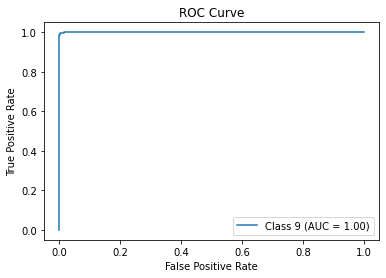

Overall AUC (macro): 0.9999


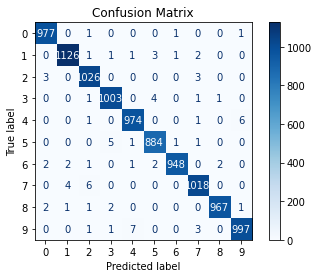

In [9]:
#Test the classifier
trainer.test_classifier(test_loader)